# Mosquito recognition project

## project owner Csaba Tóth

### collaborator: Péter Kovács

In [3]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
import torch
import shutil
import os
import random

I have added some checkpointer functionality (for saving the current best model and then reloading it at the end).

This utility can be used to reload previously saved models without starting training in the current session. To this purpose, the model number is also required as input. __Important__: do not skip providing this, otherwise you may overwrite existing logs! Naming convention for logfiles is hard-coded into the class, so you can modify that there if you like.

Also amendeded _learning rate_ and _lr decay_ parameters for slower learining and more gradual LR decrease. (You may want to play with them too!)

In [2]:
class BaseLine:
    def __init__(self,
        input_images_path_ = 'drive/My Drive/AML2020/images',
        csv_ = 'drive/My Drive/AML2020/train.csv',
        input_path_ = 'drive/My Drive/AML2020',
        train_path_ = 'drive/My Drive/AML2020/train',
        test_path_ = 'drive/My Drive/AML2020/test',
        valid_path_ = 'drive/My Drive/AML2020/validation',
                no_=0):
        
        import torch
        import torchvision
        
        self.input_images_path = input_images_path_
        self.csv = csv_
        
        self.input_path = input_path_
        self.train_path = train_path_
        self.test_path = test_path_
        self.valid_path = valid_path_
        self.no=no_

    
    def folder_generator(self):
        import pandas as pd
        import logging as log
        import os
        
        csv_labels = pd.read_csv(self.csv)
        
        images_paths = list(csv_labels['file'])
        images_paths = [path.replace('images/', '') for path in images_paths]
        
        images_labels = list(csv_labels['is_tiger'])
        counter = 1
        
        tiger_path_train = os.path.join(self.train_path, 'tiger')
        not_tiger_path_train = os.path.join(self.train_path, 'not_tiger')
        
        tiger_path_val = os.path.join(self.valid_path, 'tiger')
        not_tiger_path_val = os.path.join(self.valid_path, 'not_tiger')
        
        test_unknown_path = os.path.join(self.test_path, 'unknown')
        
        os.mkdir(self.train_path)
        os.mkdir(tiger_path_train)
        os.mkdir(not_tiger_path_train)

        os.mkdir(self.valid_path)
        os.mkdir(tiger_path_val)
        os.mkdir(not_tiger_path_val)
        
        os.mkdir(self.test_path)
        os.mkdir(test_unknown_path)
        
        #Handling Train Images
        print('###Handling Train Images')
        for image_name, image_label in zip(images_paths, images_labels):
            print('Copying image: {}, with label: {}'.format(image_name, image_label))    
            if image_name.split('_')[0] == 'train' and counter % 5 != 0:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_train))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_train))
            else:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_val))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_val))
            
    
    def data_loader(self):
        import torch
        import torchvision
        from torchvision import transforms
        
        #ImageFolder
        #Augementation for train and valid images
        
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_dataset = torchvision.datasets.ImageFolder(self.train_path, train_transforms)
        validation_dataset = torchvision.datasets.ImageFolder(self.valid_path, val_transforms)
        
        #DataLoader
        batch_size = 16
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )
        print(len(train_dataset), len(validation_dataset))
        print(len(train_dataloader), len(validation_dataloader))
        return train_dataloader, validation_dataloader
    
    def show_images(self, train_dataloader):
        
        import numpy as np
        import matplotlib.pyplot as plt
        X_batch, y_batch = next(iter(train_dataloader))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        for index in range(5):
            plt.title(y_batch[index])
            plt.imshow(X_batch[index].permute(1,2,0).numpy() * std + mean, )
            plt.show()
    
    def model(self):
        from torchvision import models
        import torch
        model = models.resnet152(pretrained=True) # orginally False - why???
        
        #Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False 

        model.fc = torch.nn.Linear(model.fc.in_features, 2)
       
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        
        loss = torch.nn.CrossEntropyLoss() # deleted crossentropy loss weigths

        
        optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=5.0e-4) # divided LR by two
       
        
        #Declay LR by a factor of 0.1 every 5th epoch
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.5) # gamma to five times
        return model, loss, optimizer, scheduler, device
    
    def train_model(self, model, loss, optimizer, scheduler, train, validation, device, num_epochs):
        import torch
        from tqdm import tqdm
        
        best_accuracy=-1
        best_path='best'+str(self.no)+'.pth'
        
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train
                    scheduler.step()
                    
                    model.train()  # Set model to training mode
                else:
                    dataloader = validation
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.
                running_acc = 0.

                # Iterate over data.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):                     
                        
                        preds = model(inputs).to(device)

                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
                
                if epoch_acc>best_accuracy and phase=='val' :
                    
                    self.create_checkpoint(model,optimizer,best_path,epoch,loss_value)
                    best_accuracy=epoch_acc
        
        
        self.load_from_checkpoint(model,optimizer,best_path)

        return model
    
    def create_checkpoint(self,model,optimizer,path,epoch,loss):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, path)
        
    def load_from_checkpoint(self,model,optimizer,path):
        
        # basically copied from the tutorial, 
        # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
        
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print('reloading best model of epoch %d, loss %f'%(checkpoint['epoch'],checkpoint['loss']))
        
    def run(self,num_ep=10):

        train_dataloader, validation_dataloader = self.data_loader()
        
        #Define model
        
        model, loss, optimizer, scheduler, device = self.model()

        #Train model 
        
        trained_model = self.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader,
                                         device, num_epochs=num_ep)
        return trained_model

# training

Just made auxiliary functions for training the five models.

__Directory structure was made before this part__ (not contained in the notebook)

Generally speaking, inside _train_ and _valid_ directories, there are _m0_,...,_m4_ directories fed into the dataloader machinery. (So with _./tiger_ and _./other_ subdirectories inside.

In [7]:
def model_(n,basedir='../'):
    
    
    
    model=BaseLine(
    train_path_=os.path.join(basedir,'images/train/m'+str(n)+'/'),
    valid_path_=os.path.join(basedir,'images/valid/m'+str(n)+'/'),
    test_path_=os.path.join(basedir,'images/test/'),
    no_=n)
    
    return model

As I did training before, I just load the model from the saved logs. (Each net eats up roughly 250 MB)

The trick is to use the training machinery that reloads the best model at the end: if you set the epoch number to 0 then it will only do this.

__Important__: the naming convention of logfiles in hard-coded into the BaseLine class definition, you only access the number of the model (0,...,4) from outside.



In [20]:
models={}
for i in range(5):
    m=model_(i)
    trained_m=m.run(num_ep=0)
    models[i]=trained_m

1144 116
72 8
reloading best model of epoch 5, loss 0.247375
1185 112
75 7
reloading best model of epoch 0, loss 0.506807
1145 122
72 8
reloading best model of epoch 1, loss 0.347989
1195 125
75 8
reloading best model of epoch 3, loss 0.308664
1126 109
71 7
reloading best model of epoch 1, loss 0.460453


# testing pipeline

Assuming that you have trained all the models, their performance should be assessed and compared to each other

This is fairly simple but requires getting hands dirty with code. To save time, I hereby present the pipeline I wrote. You may use it or write a different one.

In [60]:
import pandas as pd

In [52]:
import pickle

Conversion of model output (unactivated stuff) to confidency scores (auxiliary functions below)

In [40]:
def softmax(tensor):
    
    z=np.sum(np.exp(np.asarray(tensor)))
    
    return np.exp(np.asarray(tensor))/z
    

In [43]:
def confidency(preds):
    
    confidencies=[]
    
    for pic in range(preds.shape[0]):
        
        confidencies.append(softmax(preds[pic,:])[1]) # guess that this is the tiger probability
        
    return confidencies
        

The actual pipe, consisting of evaluating predictions on the test images in batches.

All models are loaded into memory and then set to _evaluate_ mode.

Results are stored in dictionary format: (model:(image_name:condfidency)). 

In [21]:
test_tiger_names=os.listdir('../images/test/tiger')
test_other_names=os.listdir('../images/test/other')

In [50]:
batch_size=10
counter=0
to_batch=[]
results={}

for id_,model in models.items():
    results[id_]={}
    model.eval()

for pic in test_other_names:
    to_batch.append((pic,vl_transforms(Image.open('../images/test/other/'+pic))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
        
for pic in test_tiger_names:
    to_batch.append((pic,vl_transforms(Image.open('../images/test/tiger/'+pic))))
    counter+=1
    
    if counter==batch_size:
        
        batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
        for id_,model in models.items():
            
            conf=confidency(model(batch).cpu().detach().numpy())
            
            for idx,item in enumerate(to_batch):
            
                results[id_][item[0]]=conf[idx]
                
        counter=0
        to_batch=[]
    
            
if len(to_batch)>0: #some pics remained unevaluated
    
    batch=torch.cat([(item[1].reshape(-1,3,224,224)).cuda() for item in to_batch ])
        
    for id_,model in models.items():

        conf=confidency(model(batch).cpu().detach().numpy())

        for idx,item in enumerate(to_batch):

            results[id_][item[0]]=conf[idx]

    counter=0
    to_batch=[]
        
    

Saving the results to file (safety is the best)

In [58]:
f=open('results_dictionary.txt','wb')

In [59]:
pickle.dump(results,f)

Turn the dictionary into a more manageable DataFrame

In [79]:
pd.DataFrame.from_dict(rr[0])

,train_2439.png,train_3735.png,train_1331.png,train_1797.png,train_2206.png,train_3463.png,train_2300.png,train_3821.png,train_3544.png,train_802.png,...,train_3685.png,train_3659.png,train_811.png,train_2857.png,train_2639.png,train_3031.png,train_573.png,train_3354.png,train_3875.png,train_4172.png
0,0.050849,0.157535,0.272965,0.225778,0.201483,0.657292,0.030524,0.707292,0.105765,0.076234,...,0.373777,0.697185,0.557367,0.952154,0.960871,0.757117,0.655453,0.309333,0.499517,0.430719


In [64]:
import copy

In [76]:
rr=copy.deepcopy(results)

In [77]:
for idx,model in models.items():
    for key,value in rr[idx].items():
        rr[idx][key]=list([value,])

In [78]:
type(rr[0]['train_2439.png'])

list

In [81]:
tabular_res=pd.concat([pd.DataFrame.from_dict(rr[i]) for i in range(5)])

In [86]:
tabular_res

,train_2439.png,train_3735.png,train_1331.png,train_1797.png,train_2206.png,train_3463.png,train_2300.png,train_3821.png,train_3544.png,train_802.png,...,train_3685.png,train_3659.png,train_811.png,train_2857.png,train_2639.png,train_3031.png,train_573.png,train_3354.png,train_3875.png,train_4172.png
0,0.050849,0.157535,0.272965,0.225778,0.201483,0.657292,0.030524,0.707292,0.105765,0.076234,...,0.373777,0.697185,0.557367,0.952154,0.960871,0.757117,0.655453,0.309333,0.499517,0.430719
1,0.214713,0.285193,0.503139,0.325502,0.350055,0.602504,0.158626,0.565593,0.249919,0.227207,...,0.428141,0.749099,0.646945,0.838197,0.858223,0.678448,0.676586,0.580680,0.724811,0.530995
2,0.142170,0.175650,0.333277,0.500621,0.305164,0.707267,0.064145,0.684975,0.214277,0.161016,...,0.280951,0.662838,0.508151,0.849662,0.906428,0.670640,0.597543,0.428399,0.593556,0.556293
3,0.083182,0.146282,0.338035,0.364731,0.289339,0.662985,0.056133,0.661260,0.233222,0.138187,...,0.439631,0.832469,0.595167,0.915569,0.957794,0.787573,0.637794,0.457641,0.641657,0.587652
4,0.127726,0.201568,0.238096,0.351693,0.222023,0.446872,0.076451,0.497642,0.156930,0.194802,...,0.376090,0.657026,0.521533,0.835441,0.901473,0.698255,0.480274,0.371397,0.474698,0.402718


In [85]:
tabular_res.index=[0,1,2,3,4]

In [87]:
data=tabular_res.transpose()

In [88]:
data.head()

,0,1,2,3,4
train_2439.png,0.050849,0.214713,0.142170,0.083182,0.127726
train_3735.png,0.157535,0.285193,0.175650,0.146282,0.201568
train_1331.png,0.272965,0.503139,0.333277,0.338035,0.238096
train_1797.png,0.225778,0.325502,0.500621,0.364731,0.351693
train_2206.png,0.201483,0.350055,0.305164,0.289339,0.222023


# Evaluation

This is the part what I just started to extract some impressions. 

What seems:

+ The predicted confidency scores are very much correlated (not surprisingly)
+ As you approach the average 0.5 'threshold', the predictions become more scattered and less correlated
    + Hence we may use our 5 models in this regime as an utiliy embedding pictures into a 5D space. Then the task would be building a classifier on this data. (like the PB dataset)
        + consider: selecting the appropriate regime (maybe near 0.5)
        + maybe not all nets shall have same voting power?
        + evaluate the performance of the 5D classifier on BALANCED test set!

In [92]:
import matplotlib.pyplot as plt

In [89]:
data.corr()

,0,1,2,3,4
0,1.000000,0.911949,0.950700,0.957214,0.939811
1,0.911949,1.000000,0.925330,0.931443,0.902636
2,0.950700,0.925330,1.000000,0.958799,0.940109
3,0.957214,0.931443,0.958799,1.000000,0.941893
4,0.939811,0.902636,0.940109,0.941893,1.000000


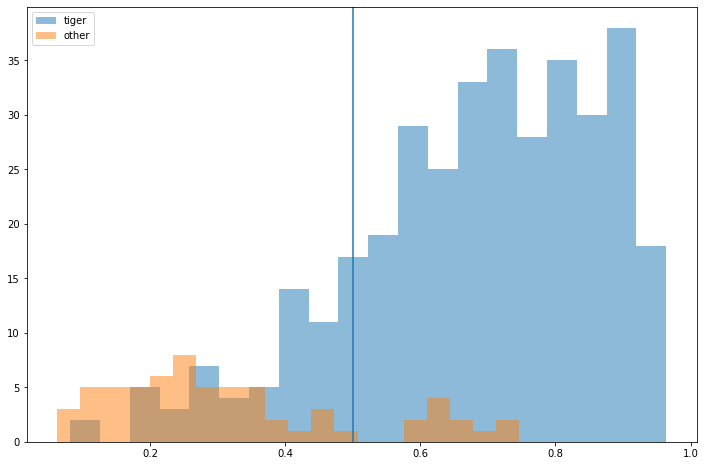

In [101]:
plt.figure(figsize=(12,8))
plt.hist(data.loc[test_tiger_names,:].mean(axis=1),bins=20,label='tiger',alpha=0.5)
plt.hist(data.loc[test_other_names,:].mean(axis=1),bins=20,label='other',alpha=0.5)
plt.axvline(0.5)
plt.legend()
plt.show()

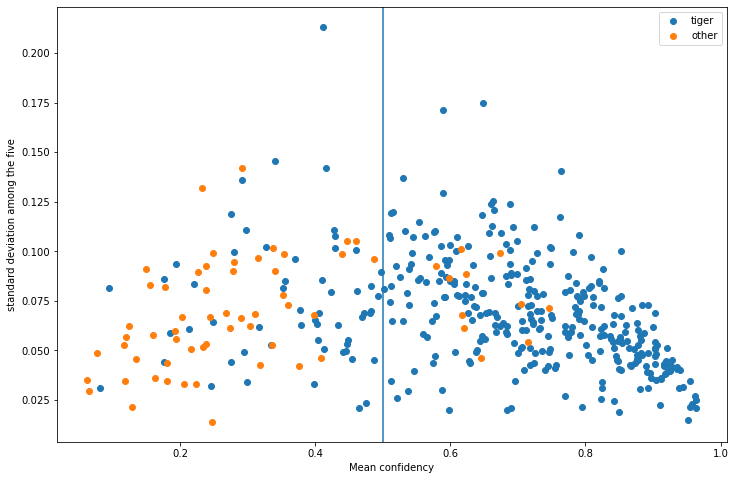

In [133]:
plt.figure(figsize=(12,8))
plt.scatter(data.loc[test_tiger_names,:].mean(axis=1),
             data.loc[test_tiger_names,:].std(axis=1),label='tiger')
plt.scatter(data.loc[test_other_names,:].mean(axis=1),
            data.loc[test_other_names,:].std(axis=1),label='other')
plt.axvline(0.5)
plt.xlabel('Mean confidency')
plt.ylabel('standard deviation among the five')
plt.legend()
plt.show()

The below 'cross' plots are only to get some feeling of the _order_ of points that may be 'saved' with a better 5D classifier.

(Eg. the ones for which the minimal and maximal confidency score would imply different predicted classes. This is only a rough estimate of course.)

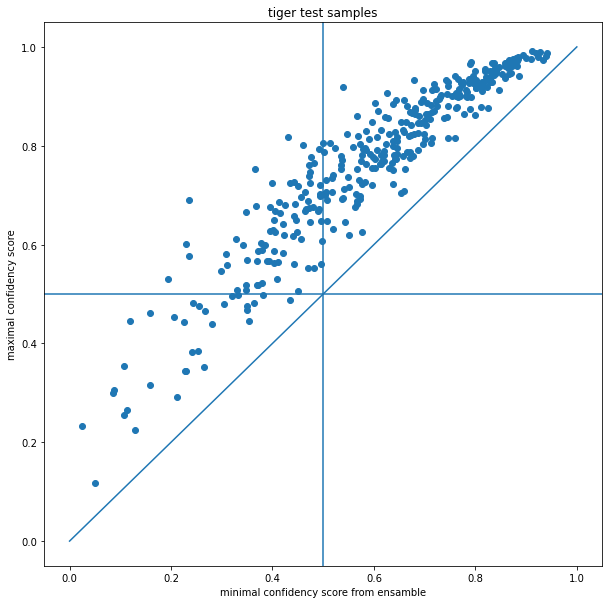

In [113]:
plt.figure(figsize=(10,10))
plt.title('tiger test samples')
plt.scatter(data.loc[test_tiger_names,:].min(axis=1),
             data.loc[test_tiger_names,:].max(axis=1),label='tiger')
# plt.scatter(data.loc[test_other_names,:].min(axis=1),
#             data.loc[test_other_names,:].max(axis=1),label='other')
plt.xlabel('minimal confidency score from ensamble')
plt.ylabel('maximal confidency score')
plt.plot([0,1],[0,1])
plt.axvline(0.5)
plt.axhline(0.5)
# plt.legend()
plt.show()

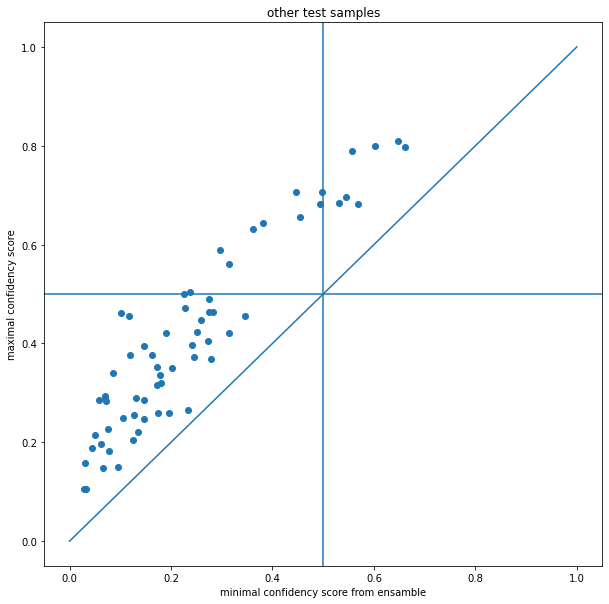

In [114]:
plt.figure(figsize=(10,10))
plt.title('other test samples')
# plt.scatter(data.loc[test_tiger_names,:].min(axis=1),
#              data.loc[test_tiger_names,:].max(axis=1),label='tiger')
plt.scatter(data.loc[test_other_names,:].min(axis=1),
            data.loc[test_other_names,:].max(axis=1),label='other')
plt.xlabel('minimal confidency score from ensamble')
plt.ylabel('maximal confidency score')
plt.plot([0,1],[0,1])
plt.axvline(0.5)
plt.axhline(0.5)
# plt.legend()
plt.show()

In [117]:
ahead_redemption=data[np.abs(0.5-data.mean(axis=1))<0.2]

In [118]:
ahead_redemption.corr() # this is the part what matters - much weaker correlations!

,0,1,2,3,4
0,1.000000,0.571526,0.729507,0.784623,0.701777
1,0.571526,1.000000,0.638491,0.681923,0.525610
2,0.729507,0.638491,1.000000,0.798214,0.680376
3,0.784623,0.681923,0.798214,1.000000,0.750732
4,0.701777,0.525610,0.680376,0.750732,1.000000


In [125]:
tiger_data=data.loc[test_tiger_names,:]
other_data=data.loc[test_other_names,:]

In [130]:
id1=3
id2=1

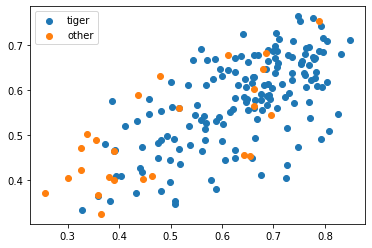

In [131]:
plt.figure()
plt.scatter(tiger_data[np.abs(0.5-tiger_data.mean(axis=1))<0.2][id1],
           tiger_data[np.abs(0.5-tiger_data.mean(axis=1))<0.2][id2],label='tiger')
plt.scatter(other_data[np.abs(0.5-other_data.mean(axis=1))<0.2][id1],
           other_data[np.abs(0.5-other_data.mean(axis=1))<0.2][id2],label='other')
plt.legend()